Necessary Libraries

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

image transformations

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),          # Tüm resimleri 128x128'e getir
    transforms.ToTensor(),                  # Görüntüyü tensor'a çevir (0-1 aralığında)
    transforms.Normalize([0.5]*3, [0.5]*3)  # RGB değerlerini [-1, 1] aralığına getir
])

We split the dataset into Train and Validation (or Val) sets

In [ ]:
import os, shutil
from sklearn.model_selection import train_test_split

# Paths to cat and dog directories
cat_dir = '/home/nabuchednezzar/Documents/VScodıe/PetImages/Cat'
dog_dir = '/home/nabuchednezzar/Documents/VScodıe/PetImages/Dog'

# Train and validation directories
train_cat = 'cats_and_dogs/train/cats'
train_dog = 'cats_and_dogs/train/dogs'
val_cat = 'cats_and_dogs/val/cats'
val_dog = 'cats_and_dogs/val/dogs'

os.makedirs(train_cat, exist_ok=True)
os.makedirs(train_dog, exist_ok=True)
os.makedirs(val_cat, exist_ok=True)
os.makedirs(val_dog, exist_ok=True)

# List files
cat_images = os.listdir(cat_dir)
dog_images = os.listdir(dog_dir)

# Split 80% train - 20% validation
cat_train, cat_val = train_test_split(cat_images, test_size=0.2, random_state=42)
dog_train, dog_val = train_test_split(dog_images, test_size=0.2, random_state=42)

# Copy
for img in cat_train:
    shutil.copy(os.path.join(cat_dir, img), os.path.join(train_cat, img))
for img in cat_val:
    shutil.copy(os.path.join(cat_dir, img), os.path.join(val_cat, img))

for img in dog_train:
    shutil.copy(os.path.join(dog_dir, img), os.path.join(train_dog, img))
for img in dog_val:
    shutil.copy(os.path.join(dog_dir, img), os.path.join(val_dog, img))

We apply transformations to the images

In [9]:
train_data = datasets.ImageFolder('cats_and_dogs/train', transform=transform)
val_data   = datasets.ImageFolder('cats_and_dogs/val', transform=transform)

We prepare the data for loading with DataLoader

In [10]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)

We define the CNN model

In [11]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 512), nn.ReLU(),
            nn.Linear(512, 2)  # 2 sınıf: kedi ve köpek
        )

    def forward(self, x):
        return self.model(x)


We send the model to the device.

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

We define the loss function and the optimizer

In [13]:
import torch.optim as optim
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training Loop

In [14]:
for epoch in range(10):  # 10 defa tüm veriyi gez
    model.train()  # Eğitim moduna geç
    total_loss = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)               # Tahmin yap
        loss = loss_fn(outputs, labels)       # Kayıp hesapla

        optimizer.zero_grad()  # Grad'leri sıfırla
        loss.backward()        # Geri yayılım
        optimizer.step()       # Ağırlıkları güncelle

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    accuracy = correct / len(train_data)
    print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Accuracy={accuracy*100:.2f}%")


/home/nabuchednezzar/.pyenv/versions/3.10.3/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1: Loss=377.9434, Accuracy=65.64%
Epoch 2: Loss=293.0814, Accuracy=77.30%
Epoch 3: Loss=250.6625, Accuracy=81.64%
Epoch 4: Loss=206.3544, Accuracy=85.44%
Epoch 5: Loss=153.2484, Accuracy=89.55%
Epoch 6: Loss=87.8050, Accuracy=94.48%
Epoch 7: Loss=41.6277, Accuracy=97.57%
Epoch 8: Loss=29.4886, Accuracy=98.37%
Epoch 9: Loss=19.8348, Accuracy=99.02%
Epoch 10: Loss=17.3779, Accuracy=99.11%


Validation

In [15]:
model.eval()  # Değerlendirme moduna geç
correct = 0

with torch.no_grad():  # Gradient hesaplama yok (daha hızlı)
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = outputs.argmax(1)
        correct += (predictions == labels).sum().item()

val_accuracy = correct / len(val_data)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Validation Accuracy: 80.80%


Visualizing the model’s predictions

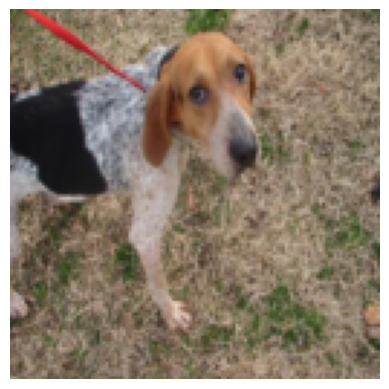

Tahmin: dogs, Gerçek: dogs


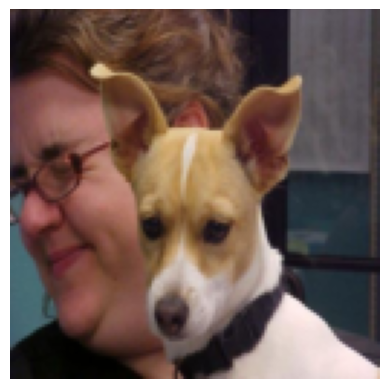

Tahmin: cats, Gerçek: dogs


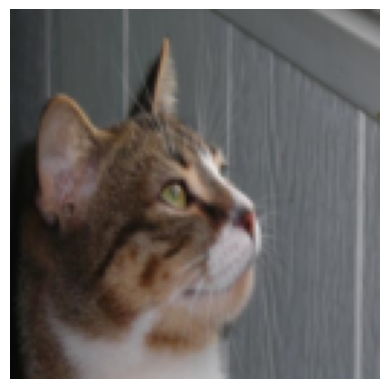

Tahmin: cats, Gerçek: cats


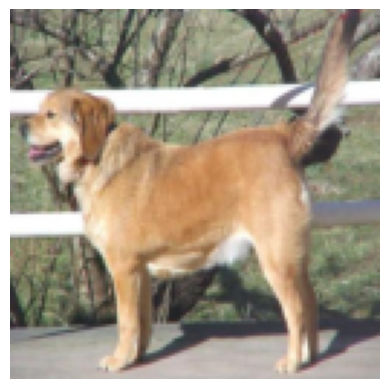

Tahmin: dogs, Gerçek: dogs


In [22]:
from torch.utils.data import Subset
import random

model.eval()
with torch.no_grad():
    indices = random.sample(range(len(val_data)), 4)
    subset = Subset(val_data, indices)
    for i in range(4):
        image, label = subset[i]
        input_tensor = image.unsqueeze(0).to(device)
        output = model(input_tensor)
        pred = output.argmax(1).item()

        # Görüntüyü göster
        imshow(image)
        print(f"Tahmin: {class_names[pred]}, Gerçek: {class_names[label]}")
